# Huấn luyện Nhận diện Cảm xúc với Dataset FER-2013
Notebook này huấn luyện mô hình CNN để nhận diện cảm xúc khuôn mặt sử dụng dataset FER-2013 đã tải về local.

**Nguồn Dataset**: https://www.kaggle.com/datasets/msambare/fer2013

In [21]:
# Import các thư viện cần thiết
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [22]:
# Khám phá cấu trúc dataset
data_dir = './dataset/emotion'
print("Cấu trúc dataset:")
for root, dirs, files in os.walk(data_dir):
    level = root.replace(data_dir, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:3]:  # Chỉ hiển thị 3 file đầu tiên
        print(f"{subindent}{file}")
    if len(files) > 3:
        print(f"{subindent}... và {len(files) - 3} file khác")

Cấu trúc dataset:
emotion/
  test/
    angry/
      PrivateTest_10131363.jpg
      PrivateTest_10304478.jpg
      PrivateTest_1054527.jpg
      ... và 955 file khác
    disgust/
      PrivateTest_11895083.jpg
      PrivateTest_19671520.jpg
      PrivateTest_21629266.jpg
      ... và 108 file khác
    fear/
      PrivateTest_10153550.jpg
      PrivateTest_10254684.jpg
      PrivateTest_10306709.jpg
      ... và 1021 file khác
    happy/
      PrivateTest_10077120.jpg
      PrivateTest_10470092.jpg
      PrivateTest_10513598.jpg
      ... và 1771 file khác
    neutral/
      PrivateTest_10086748.jpg
      PrivateTest_10767287.jpg
      PrivateTest_11123843.jpg
      ... và 1230 file khác
    sad/
      PrivateTest_10247676.jpg
      PrivateTest_10455506.jpg
      PrivateTest_10658656.jpg
      ... và 1244 file khác
    surprise/
      PrivateTest_10072988.jpg
      PrivateTest_10089743.jpg
      PrivateTest_104142.jpg
      ... và 828 file khác
  train/
    angry/
      Training_10118481

In [23]:
# Định nghĩa các lớp cảm xúc (sử dụng tất cả 7 cảm xúc từ dataset FER-2013)
emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
emotion_labels = ['Tức giận', 'Ghê tởm', 'Sợ hãi', 'Vui vẻ', 'Bình thường', 'Buồn bã', 'Ngạc nhiên']
num_classes = len(emotion_classes)

print(f"Huấn luyện với {num_classes} lớp cảm xúc: {emotion_labels}")
print("Sử dụng dataset FER-2013 đầy đủ với 7 loại cảm xúc")

Huấn luyện với 7 lớp cảm xúc: ['Tức giận', 'Ghê tởm', 'Sợ hãi', 'Vui vẻ', 'Bình thường', 'Buồn bã', 'Ngạc nhiên']
Sử dụng dataset FER-2013 đầy đủ với 7 loại cảm xúc


In [24]:
# Tiền xử lý và tăng cường dữ liệu (giảm augmentation để training nhanh hơn)
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,  # Giảm từ 20 xuống 10
    width_shift_range=0.1,  # Giảm từ 0.2 xuống 0.1
    height_shift_range=0.1,  # Giảm từ 0.2 xuống 0.1
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator cho dữ liệu validation (chỉ rescaling)
validation_datagen = ImageDataGenerator(rescale=1.0/255)

In [25]:
# Tải dữ liệu từ thư mục (tự động phát hiện các lớp cảm xúc)
# Tăng batch_size và giảm kích thước ảnh để training nhanh hơn
train_generator = train_datagen.flow_from_directory(
    directory="./dataset/emotion/train",
    target_size=(96, 96),  # Kích thước vừa phải: 96x96
    batch_size=32,  # Batch size tiêu chuẩn
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    directory="./dataset/emotion/test",
    target_size=(96, 96),  # Kích thước vừa phải: 96x96
    batch_size=32,  # Batch size tiêu chuẩn
    class_mode='categorical',
    shuffle=False
)

# In thông tin các lớp được phát hiện
detected_classes = list(train_generator.class_indices.keys())
print(f"Các lớp cảm xúc được phát hiện: {detected_classes}")
print(f"Số lượng mẫu training: {train_generator.n}")
print(f"Số lượng mẫu validation: {validation_generator.n}")

# Cập nhật số lượng lớp dựa trên dữ liệu thực tế
num_classes = len(detected_classes)
print(f"Số lượng lớp đã cập nhật: {num_classes}")

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Các lớp cảm xúc được phát hiện: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Số lượng mẫu training: 28709
Số lượng mẫu validation: 7178
Số lượng lớp đã cập nhật: 7


In [26]:
# Xây dựng mô hình CNN cho nhận diện cảm xúc (tối ưu hóa cho tốc độ)
model = Sequential()

# Các lớp Convolutional (cân bằng giữa tốc độ và chất lượng)
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# Flatten
model.add(Flatten())

# Các lớp fully-connected
model.add(Dense(128, activation='relu'))  # Tăng lại lên 128 để cân bằng
model.add(Dropout(0.4))  # Dropout vừa phải

# Lớp output
model.add(Dense(num_classes, activation='softmax'))

# Hiển thị kiến trúc mô hình
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 10, 10, 128)      

In [27]:
# Compile mô hình với optimizer Adam (thường nhanh hơn RMSprop)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks để tối ưu hóa training
early_stopping = EarlyStopping(
    patience=3, 
    monitor='val_loss', 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.0001
)

In [28]:
# Huấn luyện mô hình (giảm epochs để training nhanh hơn)
print("Bắt đầu huấn luyện mô hình...")
history = model.fit(
    train_generator,
    steps_per_epoch=min(200, train_generator.n // train_generator.batch_size),  # Tăng steps để cân bằng
    epochs=15,  # Tăng epochs lên 15
    validation_data=validation_generator,
    validation_steps=min(100, validation_generator.n // validation_generator.batch_size),  # Tăng validation steps
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
print("Hoàn thành huấn luyện!")

Bắt đầu huấn luyện mô hình...
Epoch 1/15
200/200 [==============================] - 41s 204ms/step - loss: 1.8339 - accuracy: 0.2324 - val_loss: 1.7966 - val_accuracy: 0.3403 - lr: 0.0010
Epoch 2/15
200/200 [==============================] - 68s 337ms/step - loss: 1.7841 - accuracy: 0.2670 - val_loss: 1.8038 - val_accuracy: 0.2775 - lr: 0.0010
Epoch 3/15
200/200 [==============================] - 54s 267ms/step - loss: 1.7587 - accuracy: 0.2732 - val_loss: 1.8616 - val_accuracy: 0.2259 - lr: 0.0010
Epoch 4/15
200/200 [==============================] - 53s 267ms/step - loss: 1.7363 - accuracy: 0.2853 - val_loss: 1.7583 - val_accuracy: 0.2853 - lr: 2.0000e-04
Epoch 5/15
200/200 [==============================] - 54s 267ms/step - loss: 1.7103 - accuracy: 0.3047 - val_loss: 1.7378 - val_accuracy: 0.2844 - lr: 2.0000e-04
Epoch 6/15
200/200 [==============================] - 45s 225ms/step - loss: 1.6924 - accuracy: 0.3258 - val_loss: 1.7050 - val_accuracy: 0.3300 - lr: 2.0000e-04
Epoch 7/15

In [29]:
# Đánh giá mô hình
score = model.evaluate(validation_generator, verbose=0)
print(f'Loss trên tập test: {score[0]:.4f}')
print(f'Độ chính xác trên tập test: {score[1]:.4f}')

Loss trên tập test: 1.4275
Độ chính xác trên tập test: 0.4604


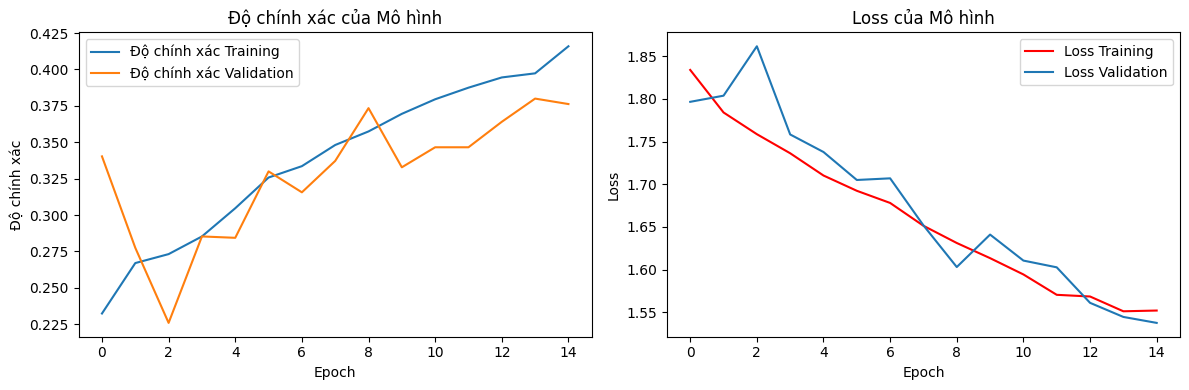

In [30]:
# Vẽ biểu đồ lịch sử huấn luyện
plt.figure(figsize=(12, 4))

# Vẽ biểu đồ độ chính xác
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Độ chính xác Training')
plt.plot(history.history['val_accuracy'], label='Độ chính xác Validation')
plt.title('Độ chính xác của Mô hình')
plt.ylabel('Độ chính xác')
plt.xlabel('Epoch')
plt.legend()

# Vẽ biểu đồ loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'r', label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Validation')
plt.title('Loss của Mô hình')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [31]:
# Lưu mô hình đã huấn luyện
model.save('Emotion1.h5')
print("Mô hình đã được lưu với tên 'Emotion1.h5'")

Mô hình đã được lưu với tên 'Emotion1.h5'


In [32]:
# Kiểm tra mô hình với ảnh mẫu
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

# Tải mô hình đã lưu
model_CNN = load_model('Emotion1.h5')

# Định nghĩa nhãn dự đoán (tự động phát hiện từ dataset)
# Lưu ý: Thứ tự phải khớp với class indices khi training
try:
    # Thử tải class indices từ file đã lưu hoặc sử dụng mặc định
    predict_labels = ['Tức giận', 'Ghê tởm', 'Sợ hãi', 'Vui vẻ', 'Bình thường', 'Buồn bã', 'Ngạc nhiên']
    print(f"Sử dụng nhãn dự đoán: {predict_labels}")
except:
    predict_labels = ['Cảm_xúc_0', 'Cảm_xúc_1', 'Cảm_xúc_2', 'Cảm_xúc_3', 'Cảm_xúc_4', 'Cảm_xúc_5', 'Cảm_xúc_6']
    print(f"Sử dụng nhãn mặc định: {predict_labels}")

# Hàm dự đoán cảm xúc từ đường dẫn ảnh
def predict_emotion(image_path):
    try:
        # Tải và tiền xử lý ảnh
        img = load_img(image_path, target_size=(96, 96))  # Cập nhật kích thước
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title('Ảnh đầu vào')
        plt.axis('off')
        plt.show()
        
        # Chuyển đổi thành array và chuẩn hóa
        img_array = img_to_array(img)
        img_array = img_array.reshape(1, 96, 96, 3)  # Cập nhật kích thước
        img_array = img_array.astype('float32') / 255.0
        
        # Thực hiện dự đoán
        prediction = model_CNN.predict(img_array)
        predicted_class = np.argmax(prediction, axis=-1)[0]
        confidence = np.max(prediction)
        
        print(f"Cảm xúc dự đoán: {predict_labels[predicted_class]}")
        print(f"Độ tin cậy: {confidence:.2%}")
        
        return predict_labels[predicted_class], confidence
    except Exception as e:
        print(f"Lỗi khi xử lý ảnh: {e}")
        return None, None

# Ví dụ sử dụng (bỏ comment và cung cấp đường dẫn ảnh hợp lệ)
# predict_emotion('./dataset/emotion/test/happy/sample_image.jpg')

Sử dụng nhãn dự đoán: ['Tức giận', 'Ghê tởm', 'Sợ hãi', 'Vui vẻ', 'Bình thường', 'Buồn bã', 'Ngạc nhiên']
